In [19]:
from Bio.PDB import MMCIFParser
import tmtools
import numpy as np
import matplotlib.pyplot as plt

<h1>Calculate TM-scores and pLDDTs</h1>

In [20]:
def get_data_from_cif(path):
    """
    Parses a CIF file from AlphaFold to extract coordinates and sequence
    :return:
    """
    one_letter_dic = {
        'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
        'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
        'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
        'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
    }
    parser = MMCIFParser()
    structure = parser.get_structure("struct", path)
    model = structure[0]
    chain = next(iter(model))

    coords = []
    seq_list = []
    plddts = []  

    for residue in chain:
        if "CA" not in residue:
            continue
        ca_coord = residue["CA"].get_coord() # get coordinates of the C-alpha
        res_name = one_letter_dic[residue.get_resname()]

        coords.append(ca_coord)
        seq_list.append(res_name)
        
        plddt_score = residue["CA"].get_bfactor()
        plddts.append(plddt_score)

    return np.array(coords, dtype=float), "".join(seq_list), np.array(plddts, dtype=float)

In [26]:
def plot_TM_score(tm_scores):
    plt.figure(figsize=(14, 8))
    plt.plot([0.1, 0.2, 0.3, 0.4], tm_scores, 
             marker='o', 
             linestyle='-', 
             color='royalblue', 
             linewidth=2, 
             markersize=8, 
             label='Mutant Structure')
    
    # TM-score < 0.5 -> the fold is broken
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Fold Broken (< 0.5)')
    # TM-score > 0.9 -> identical topology
    plt.axhline(y=0.9, color='green', linestyle=':', alpha=0.5, label='Structure Identical (> 0.9)')
    plt.xlim(0, 1.0)
    plt.ylim(0, 1.0)
    
    plt.title("Impact of Random Mutations on Protein Structure", fontsize=14, fontweight='bold')
    plt.xlabel("Mutation Probability", fontsize=12)
    plt.ylabel("TM-Score (vs Original Sequence)", fontsize=12)
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()

In [27]:
def calculate_scores(ori_path, mut_path):
    ori_coords, ori_seq, ori_plddt = get_data_from_cif(ori_path)

    tm_scores = []    
    plddts_scores = []
    
    
    for i in range(1, 5):
        cif_name = mut_path+f"_0.{i}.cif"
        mut_coords, mut_seq, mut_plddt = get_data_from_cif(cif_name)
        
        # TM-Score
        res = tmtools.tm_align(ori_coords, mut_coords, ori_seq, ori_seq)
        score = res.tm_norm_chain1
        tm_scores.append(score)
        
        # delta pLDDT Score
        delta_plddt = mut_plddt - ori_plddt
        residue_indices = range(1, len(ori_plddt) + 1)
        plddts_scores.append(delta_plddt)
        
        plt.figure(figsize=(12, 6))
        plt.axhline(0, color='black', linewidth=1, linestyle='-')
        colors = ['red' if x < -10 else 'grey' for x in delta_plddt]
        
        plt.bar(residue_indices, delta_plddt, color=colors, alpha=0.7)
        plt.xlabel("Residue Index")
        plt.ylabel("Δ pLDDT (Mutated - Original)")
        # significant drops
        plt.axhline(-10, color='red', linestyle='--')
        
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.savefig(f"plots/pLDDTs/p=0.{i}.png")
        plt.show()
        
    return tm_scores, plddts_scores

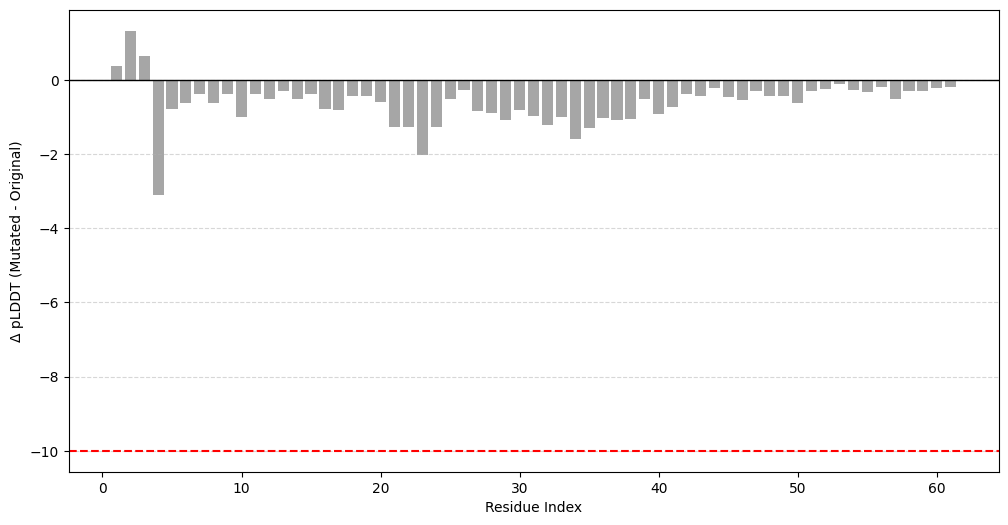

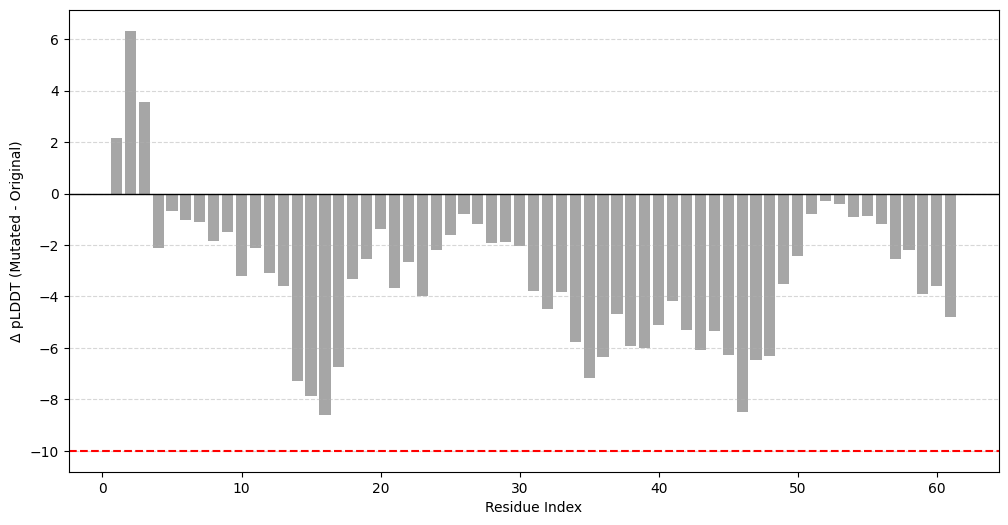

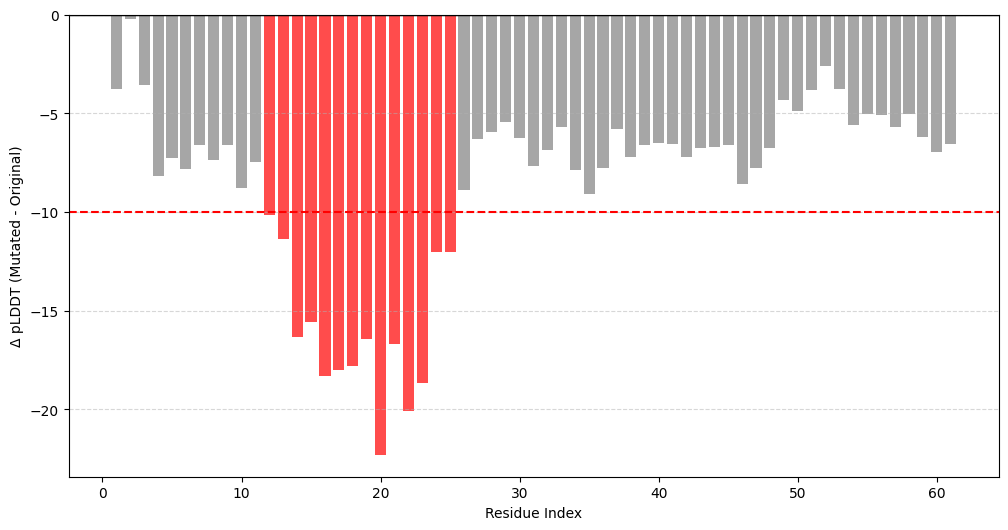

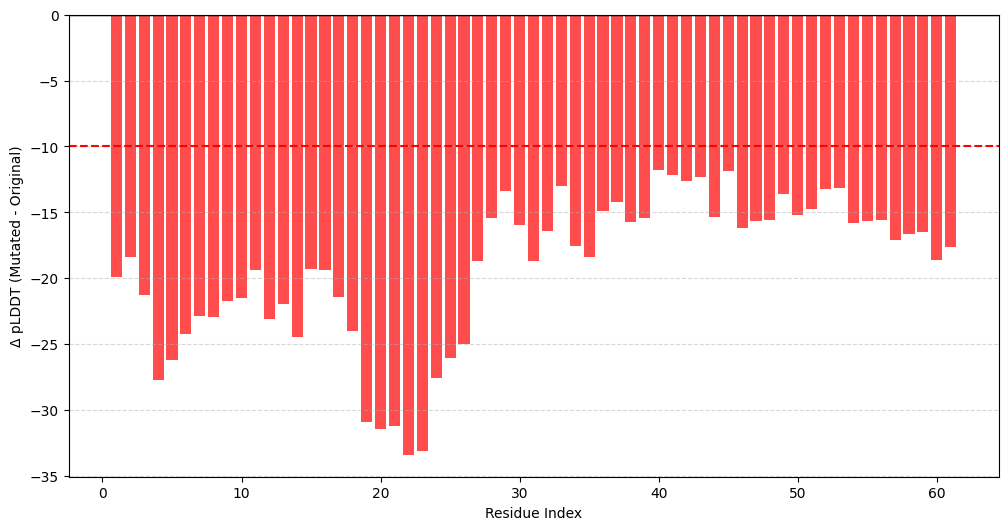

In [28]:
tm_scores, plddt_scores = calculate_scores("structures/ori/ori.cif", "structures/mutated/mut")

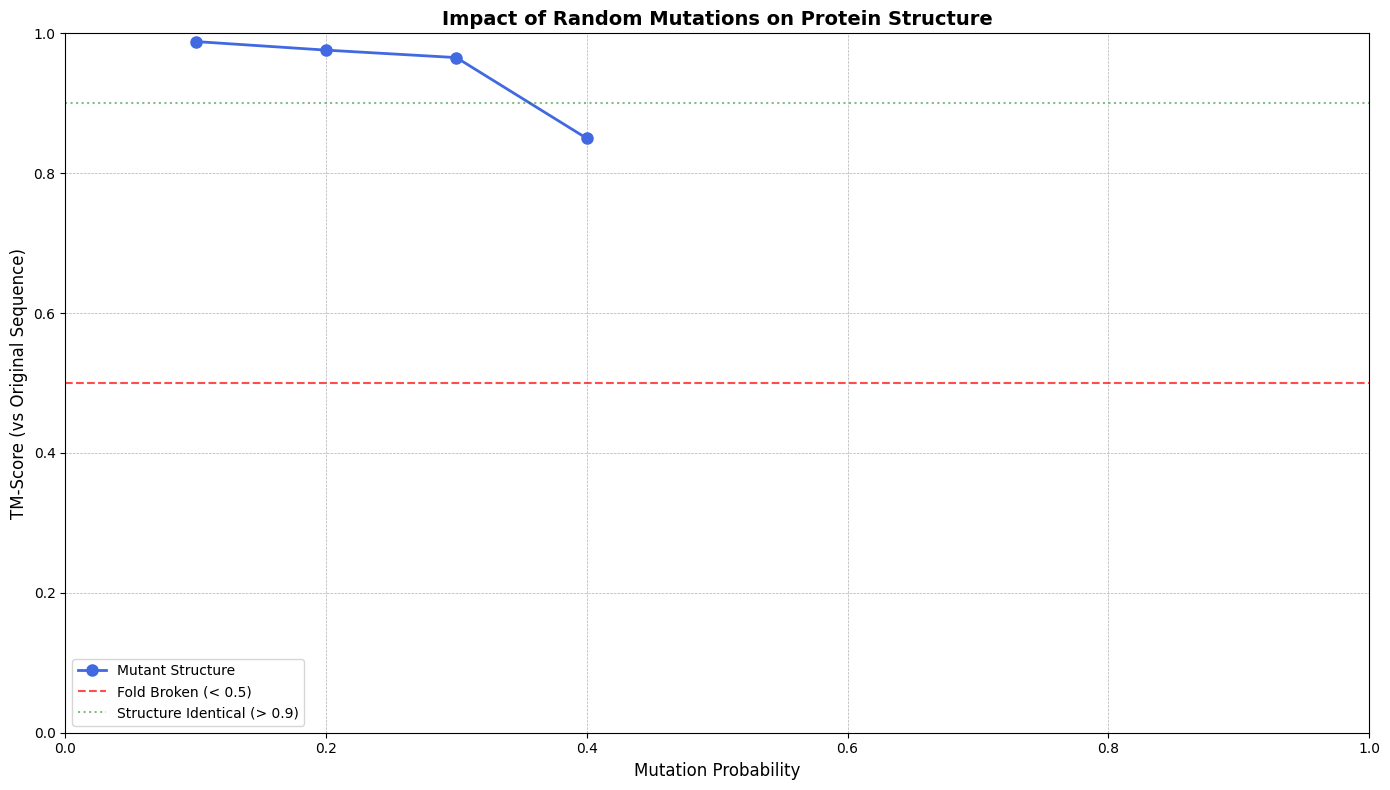

In [29]:
plot_TM_score(tm_scores)

<h1>Get xposy for DDGun</h1>

In [30]:
def get_xposy(ori_file, mut_file):
    """
    Get xposy for DDGun 
    """
    with open(ori_file, "r") as f:
        ori = "".join(line.strip() for line in f)

    with open(mut_file, "r") as f:
        mut = "".join(line.strip() for line in f)

    assert len(ori) == len(mut), "Original and mutant sequences must be the same length"

    xposy = ""
    for i, (o, m) in enumerate(zip(ori, mut), start=1):
        if o != m:
            xposy += f"{o}{i}{m}\n"

    print(xposy)

In [16]:
get_xposy("sequences/mutated/deterministic/seq_p_0.1.txt", "sequences/original/original.txt")

A2T
T19G
A33K
A35F
T47V
A52D
